In [1]:
import pandas as pd 
import numpy as np 

import matplotlib.pyplot as plt 
import cv2 as cv 

from keras.layers import (Conv2D, Input, LeakyReLU, Dense, Activation, Flatten,
                          Dropout, MaxPool2D)
from keras import models 
from keras.optimizers import Adam, RMSprop
from keras.preprocessing.image import ImageDataGenerator 
from keras.callbacks import ReduceLROnPlateau 

import pickle 

%matplotlib inline 

In [2]:
np.random.seed(1) 
df_train = pd.read_csv("train.csv") #load training data 
#df_train = df_train[0:25000]
df_train = df_train.iloc[np.random.permutation(len(df_train))] #randomize data 

In [3]:
df_train.head(5)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
29633,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
345,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
36369,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16624,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14389,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
df_train.shape

(42000, 785)

In [5]:
sample_size = df_train.shape[0] #Training set size 
validation_size = int(df_train.shape[0]*0.2) #Validation set (20% data)

train_x = np.asarray(df_train.iloc[:sample_size-validation_size:,1:]).reshape([sample_size-validation_size,28,28,1]) #input columns
train_y = np.asarray(df_train.iloc[:sample_size-validation_size,0]).reshape([sample_size-validation_size,1]) #desired output column(column 0)

val_x = np.asarray(df_train.iloc[sample_size-validation_size:,1:]).reshape([validation_size,28,28,1])
val_y = np.asarray(df_train.iloc[sample_size-validation_size:,0]).reshape([validation_size,1])


In [6]:
train_x.shape,train_y.shape #shape of training set 

((33600, 28, 28, 1), (33600, 1))

In [7]:
df_test = pd.read_csv("test.csv") #load test data
test_x = np.asarray(df_test.iloc[:,:]).reshape([-1,28,28,1]) #data into numpy array and reshape

In [8]:
#normalize data 
#divide by max pixel value range
train_x = train_x/255
val_x = val_x/255
test_x = test_x/255

<function matplotlib.pyplot.show(close=None, block=None)>

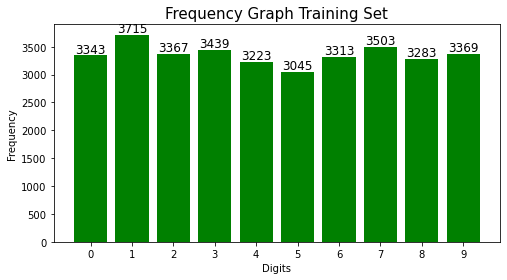

In [9]:
#frequency check training set 
counts = df_train.iloc[:sample_size-validation_size,:].groupby('label')['label'].count()
f = plt.figure(figsize=(8,4))
f.add_subplot(111)

plt.bar(counts.index,counts.values,width = 0.8, color = "green")
for i in counts.index: 
    plt.text(i,counts.values[i]+50,str(counts.values[i]),horizontalalignment='center',fontsize=12)
    
plt.tick_params(labelsize = 10)
plt.xticks(counts.index)
plt.xlabel("Digits",fontsize = 10)
plt.ylabel("Frequency", fontsize = 10)
plt.title("Frequency Graph Training Set", fontsize = 15)
plt.savefig('digit_freq_train.png')
plt.show

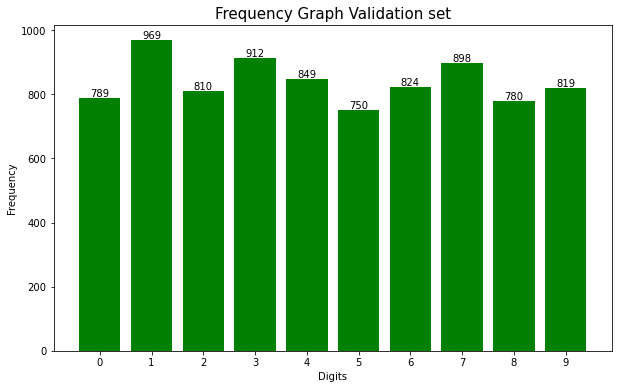

In [10]:
#frequency check validation set 
counts = df_train.iloc[sample_size-validation_size:,:].groupby('label')['label'].count()

f = plt.figure(figsize=(10,6))
f.add_subplot(111)

plt.bar(counts.index,counts.values,width = 0.8, color = "green")
for i in counts.index: 
    plt.text(i,counts.values[i]+5,str(counts.values[i]),horizontalalignment='center',fontsize = 10)

plt.tick_params(labelsize=10)
plt.xticks(counts.index)
plt.xlabel("Digits",fontsize = 10)
plt.ylabel("Frequency", fontsize = 10)
plt.title("Frequency Graph Validation set", fontsize = 15)
plt.savefig('digit_freq_validation.png')
plt.show()


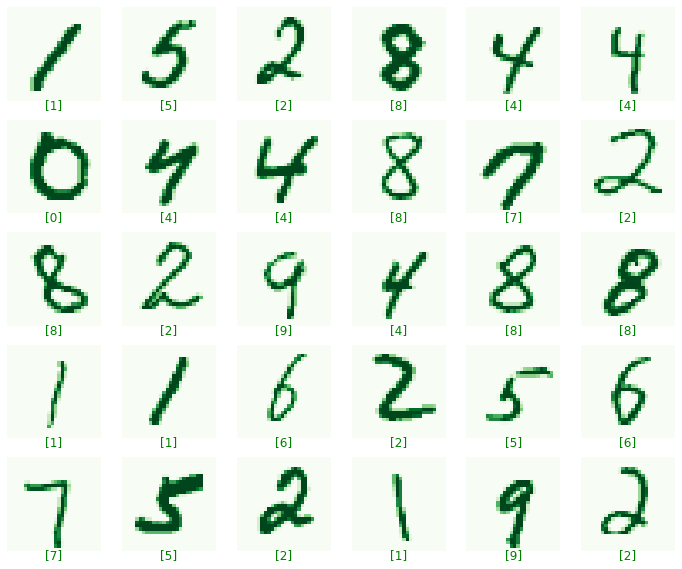

In [11]:
#visualize first 30 images w/ labels
rows = 5 
cols = 6

f = plt.figure(figsize = (2*cols,2*rows)) #define figure

for i in range(rows*cols): 
    f.add_subplot(rows,cols,i+1) 
    plt.imshow(train_x[i].reshape([28,28]),cmap = "Greens")
    plt.axis("off")
    plt.title(str(train_y[i]), y = -0.15, color = "green")
    
plt.savefig("digit_visual.png")


In [12]:
model = models.Sequential() #stack of layers 

In [13]:
# convolutional block 1
model.add(Conv2D(32,3,padding = "same",input_shape = (28,28,1))) #2D convolutional layer
model.add(LeakyReLU()) #leakyReLU activation layer
model.add(Conv2D(32,3, padding = "same")) #2D convolutional layer 
model.add(LeakyReLU()) #leakyReLU activation layer 
model.add(MaxPool2D(pool_size = (2,2))) #reduce size of image 
model.add(Dropout(0.25)) #drop activation notes(regularization)

# convolutional block 2 
model.add(Conv2D(64,3, padding = "same")) #2D convolutional layer 
model.add(LeakyReLU()) #Leaky ReLU activation layer 
model.add(Conv2D(64,3,padding = "same"))
model.add(LeakyReLU())
model.add(MaxPool2D(pool_size = (2,2))) #reduce size of image 
model.add(Dropout(0.25)) #drop activation notes(regularization)

model.add(Flatten()) #flatten layer 

#dense layer and output layer 
model.add(Dense(256,activation = 'relu'))
model.add(Dense(32,activation = 'relu'))
model.add(Dense(10,activation = "sigmoid"))

In [14]:
#optimizer and loss function 
initial_lr = 0.001 #learning rate 
loss = "sparse_categorical_crossentropy" #loss function 
model.compile(RMSprop(lr = initial_lr), loss=loss, metrics = ['accuracy']) #RMS optimizer 
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        1

In [15]:
#build/train model 
epochs = 20 #epochs take long 
batch_size = 200
history_1 = model.fit(train_x, train_y, batch_size = batch_size, epochs = epochs, 
                      validation_data = (val_x,val_y))


Epoch 1/20
168/168 [==============================] - 82s 480ms/step - loss: 0.7637 - accuracy: 0.7410 - val_loss: 0.0848 - val_accuracy: 0.9760
Epoch 2/20
168/168 [==============================] - 78s 466ms/step - loss: 0.0750 - accuracy: 0.9764 - val_loss: 0.0606 - val_accuracy: 0.9811
Epoch 3/20
168/168 [==============================] - 78s 462ms/step - loss: 0.0459 - accuracy: 0.9859 - val_loss: 0.0500 - val_accuracy: 0.9852
Epoch 4/20
168/168 [==============================] - 81s 484ms/step - loss: 0.0355 - accuracy: 0.9890 - val_loss: 0.0385 - val_accuracy: 0.9881
Epoch 5/20
168/168 [==============================] - 77s 457ms/step - loss: 0.0250 - accuracy: 0.9920 - val_loss: 0.0426 - val_accuracy: 0.9867
Epoch 6/20
168/168 [==============================] - 74s 440ms/step - loss: 0.0224 - accuracy: 0.9926 - val_loss: 0.0492 - val_accuracy: 0.9868
Epoch 7/20
168/168 [==============================] - 74s 441ms/step - loss: 0.0167 - accuracy: 0.9946 - val_loss: 0.0445 - val_ac

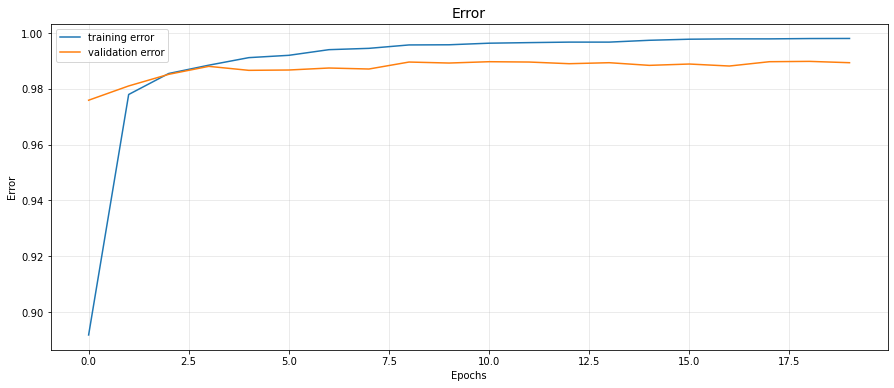

In [16]:
#training 
f = plt.figure(figsize = (15,6)) #figure 

plt.plot(history_1.epoch,history_1.history['accuracy'], label = "training error") #accuracy curve 
plt.plot(history_1.epoch,history_1.history['val_accuracy'], label = "validation error") #validation accuracy curve

plt.title("Error", fontsize = 14)
plt.xlabel("Epochs", fontsize = 10)
plt.ylabel("Error", fontsize = 10)
plt.grid(alpha = 0.3)
plt.legend()

plt.savefig('Error_graph.png')
plt.show()


In [17]:
#validation error 
val_d = np.argmax(model.predict(val_x),axis = 1)

error = 0
for i in range(val_x.shape[0]):
    if val_y[i] != val_d[i]:
        error = error+1
        
        
print("Errors in validation set: ", error)
print("\nError Persentage: " , (error*100)/val_d.shape[0])


Errors in validation set:  98

Error Persentage:  1.1666666666666667


In [18]:
val_d.shape[0]

8400

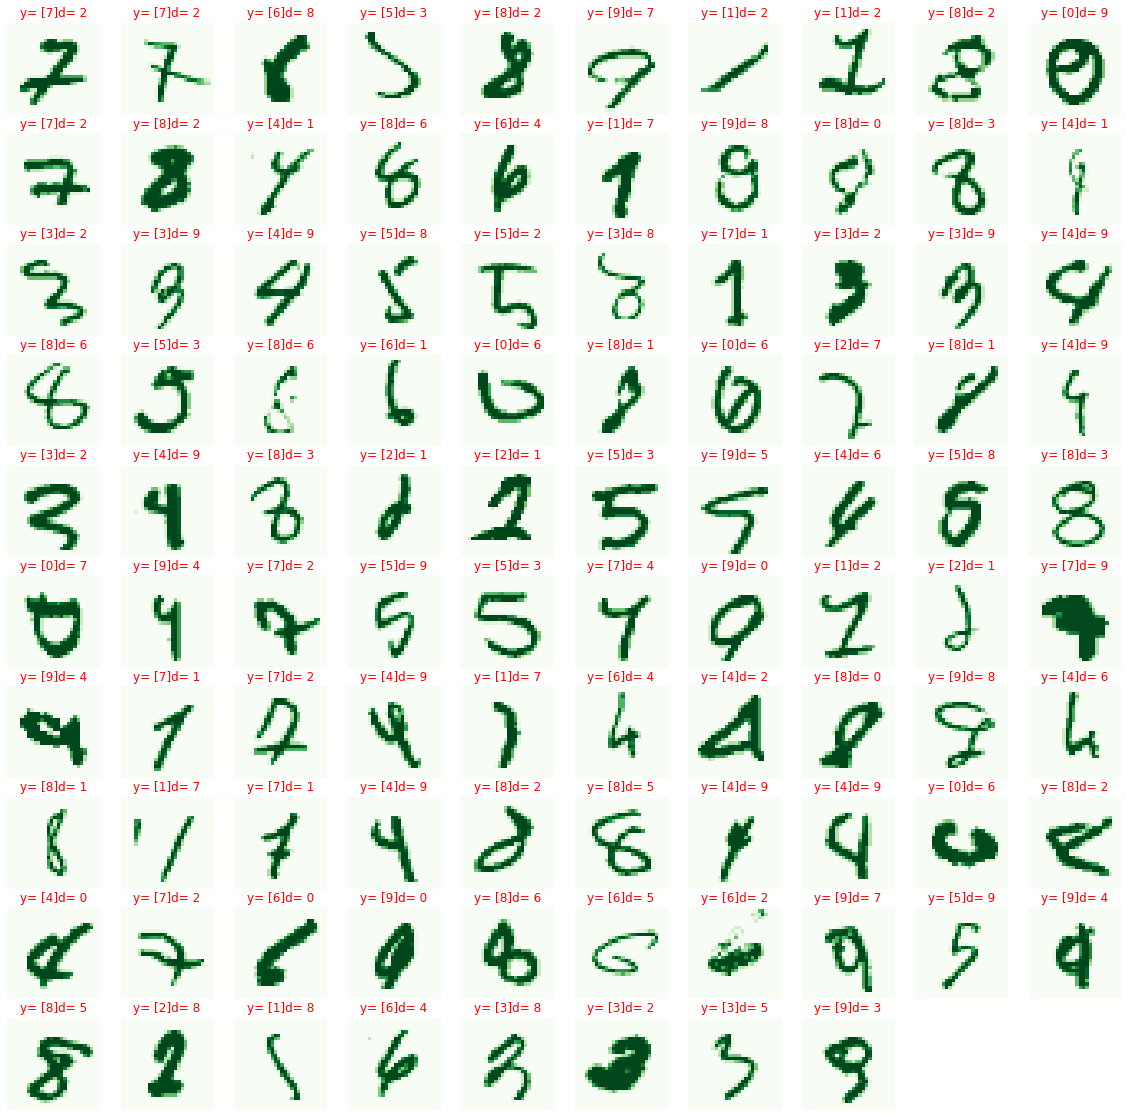

In [20]:
#misclassified data
rows = 10
cols = 10

f = plt.figure(figsize = (2*cols,2*rows))
subplot = 1 
for i in range(val_x.shape[0]):
    if val_y[i] != val_d[i]:
        f.add_subplot(rows,cols,subplot)
        subplot +=1
        plt.imshow(val_x[i].reshape([28,28]),cmap = 'Greens')
        plt.axis("off")
        plt.title("y= " + str(val_y[i]) + "d= " + str(val_d[i]), color = "Red")
plt.savefig("misclassified_data.png")
plt.show()

In [21]:
num = np.arange(10)
error_num = np.zeros((10,1))

for i in range(val_x.shape[0]):
    if val_y[i]!= val_d[i]:
        for j in num:
            if val_d[i] == num[j]:
                error_num[j] +=1
  
print(error_num) #number of misclassified data for each classifier 

[[ 6.]
 [12.]
 [21.]
 [ 8.]
 [ 7.]
 [ 5.]
 [ 9.]
 [ 7.]
 [ 9.]
 [14.]]
